<a href="https://colab.research.google.com/github/chen-star/llm_model_trainings/blob/main/5_4_fine_tuning_gradient_clipping_and_lr_scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ⭐ Fine-tuning ⭐

---

**Gradient Clipping**

* *Clipping*: replace extreme values (outliers)  with a maximum threshold value.

* *Gradient Clipping*: scale down or clip gradient to a maxium allowed value.

Why?

> During training, especially with large models, gradients can sometimes become very large. This phenomenon is known as exploding gradients. When gradients explode, they can cause the model's parameters to be updated drastically, leading to unstable training and potentially preventing the model from converging to a good solution.


**Learning Rate Scheduler**

* *learning rate scheduler*: dynamically adjust the learning rate over time, rather than keeping it constant throughout the entire training process.

How?

> The idea is often to use a higher learning rate in the beginning to make rapid progress through the loss landscape, and then gradually decrease it later in training to fine-tune the model and converge more precisely.

---

# ✈ Imports

In [1]:
from transformers import BertModel, BertTokenizer
from transformers import get_cosine_schedule_with_warmup,get_linear_schedule_with_warmup
from datasets import load_dataset, DatasetDict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

!pip install torchinfo
from torchinfo import summary

from typing import override

# 🔢 Hyperparameters

In [2]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# 📂 Prepare Training Data

In [3]:
# import BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
# import IMDB dataset
dataset = load_dataset('imdb')
# only keep a sub set of data
dataset = DatasetDict({split:dataset[split].select(range(5_000, 20_000)) for split in ['train','test']})

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
# tokenize dataset
tokenized_dataset = \
    dataset.map(lambda data: tokenizer(data['text'], max_length=512, truncation=True, padding='max_length'), batched=True)\
    .remove_columns(['text'])\
    .with_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [6]:
# Train / Test dataset
train_dataloader = DataLoader(tokenized_dataset['train'], shuffle=True, batch_size=32)
test_dataloader  = DataLoader(tokenized_dataset['test'], batch_size=32)

In [7]:
next(iter(train_dataloader))

{'label': tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
         1, 0, 0, 1, 0, 1, 1, 0]),
 'input_ids': tensor([[  101,  2092,  2256,  ...,     0,     0,     0],
         [  101,  2023,  2987,  ..., 11519,  2466,   102],
         [  101, 10731, 17936,  ...,     0,     0,     0],
         ...,
         [  101,  1000,  2709,  ...,     0,     0,     0],
         [  101,  2108,  1037,  ...,  1016,  1997,   102],
         [  101,  2058,  1996,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]])}

# [0] 🏚 Model

In [8]:
num_classes = 2

# use Bert model in a custom model
class BertClassificationMode(nn.Module):
  def __init__(self, bert_model, num_classes):
    super(BertClassificationMode, self).__init__()

    # Use the pre-trained BERT model
    self.bert = BertModel.from_pretrained('bert-base-uncased')

    # final classfier layer input is 786 dimension, output is 2 dimension
    self.classifier = nn.Linear(768, num_classes)
    p = self.bert.embeddings.dropout.p
    self.dropout = nn.Dropout(p)

    # init classifier weights and biases
    nn.init.xavier_uniform_(self.classifier.weight)
    nn.init.zeros_(self.classifier.bias)


  def forward(self, input_ids, attention_mask=None, token_type_ids=None):
    bert_outputs = self.bert(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
    )

    logits = self.classifier(self.dropout(bert_outputs.pooler_output))
    return logits


In [9]:
model = BertClassificationMode(bert, num_classes).to(device)
model

BertClassificationMode(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

**Freeze Attention blocks and embedding layers**

In [10]:
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for layer in model.bert.encoder.layer:
    for param in layer.attention.parameters():
        param.requires_grad = False

trainable_params = 0
frozen_params = 0

for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params += param.numel()
    else:
        frozen_params += param.numel()

total_params = trainable_params + frozen_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")
print(f"Percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%")

Total parameters: 109,483,778
Trainable parameters: 57,279,746
Frozen parameters: 52,204,032
Percentage of trainable parameters: 52.32%


# [1] ⛰ Learning Rate Scheduler

In [11]:
# sample size
sample_size = 200

In [12]:
# optimizers
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5)

In [13]:
# scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(sample_size * 0.2), # 20% warmup
    num_training_steps=int(sample_size * 1.2) # prevent learning rate going down to 0
)

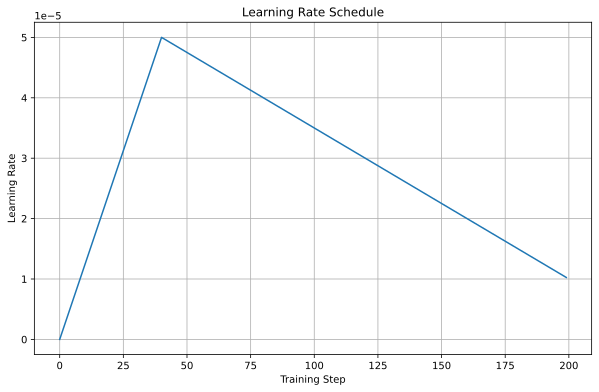

In [14]:
# Visualize how learning rate changes over epoch
lrs = []

# Iterate through the scheduler steps to collect learning rates
for _ in range(sample_size):
    optimizer.step()  # Dummy step to update internal state for LR
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

# Plot the learning rates
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

In [15]:
# re-define scheduler and optimizer again to be used in fine-tuning
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(sample_size * 0.2), # 20% warmup
    num_training_steps=int(sample_size * 1.2) # prevent learning rate going down to 0
)

# [2] 🔘 Fine-tuning

In [16]:
# loss func
loss_func = nn.CrossEntropyLoss()

In [17]:
# init losses
train_loss = []
test_loss = []

In [18]:
# norms
norms = np.zeros((sample_size, 2))

In [19]:
for i in range(sample_size):

  # get input data X
  X = next(iter(train_dataloader))
  X_token_ids = X['input_ids'].to(device)
  X_attention_mask = X['attention_mask'].to(device)
  X_labels = X['label'].to(device)

  # ----- Fine-tuning -----

  # clear previous gradients
  model.zero_grad(set_to_none=True)

  # forward
  logits = model(X_token_ids, X_attention_mask)
  outputLabel = torch.argmax(logits, dim=1)

  # calc loss
  loss = loss_func(logits, X_labels)
  # save loss
  train_loss.append(loss.item())

  # back propagate
  loss.backward()

  norms[i,0] = torch.norm(model.bert.encoder.layer[7].output.dense.weight.grad).item()
  norms[i,1] = torch.norm(model.classifier.weight.grad).item()

  # gradient clipping
  nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

  # update weights
  optimizer.step()
  # update lr
  scheduler.step()


  # ----------------------------------------------------------------------

  # ***** Test during Fine-tuning *****
  if i % 20 == 0:
    model.eval()
    with torch.no_grad():
      # get input data X
      X = next(iter(test_dataloader))
      X_token_ids = X['input_ids'].to(device)
      X_attention_mask = X['attention_mask'].to(device)
      X_labels = X['label'].to(device)

      # forward
      logits = model(X_token_ids, X_attention_mask)
      outputLabel = torch.argmax(logits, dim=1)

      # calc loss
      loss = loss_func(logits, X_labels)
      # save loss
      test_loss.append(loss.item())

      model.train()

      # print progress
      print(f"Iteration {i}/{sample_size}: Train Loss = {train_loss[-1]:.4f}, Test Loss = {test_loss[-1]:.4f}")

Iteration 0/200: Train Loss = 0.7997, Test Loss = 0.4179
Iteration 20/200: Train Loss = 0.6090, Test Loss = 0.7842
Iteration 40/200: Train Loss = 0.3624, Test Loss = 0.1231
Iteration 60/200: Train Loss = 0.4128, Test Loss = 0.1298
Iteration 80/200: Train Loss = 0.1422, Test Loss = 0.2535
Iteration 100/200: Train Loss = 0.2769, Test Loss = 0.4879
Iteration 120/200: Train Loss = 0.2052, Test Loss = 0.2894
Iteration 140/200: Train Loss = 0.1348, Test Loss = 0.1157
Iteration 160/200: Train Loss = 0.3417, Test Loss = 0.2209
Iteration 180/200: Train Loss = 0.4830, Test Loss = 0.1714


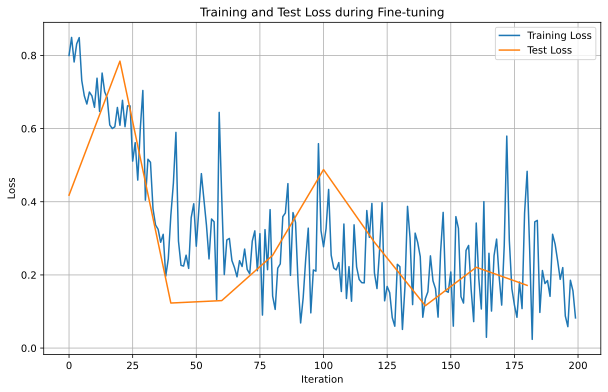

In [20]:
# plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot([i * 20 for i in range(len(test_loss))], test_loss, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Test Loss during Fine-tuning')
plt.legend()
plt.grid(True)
plt.show()